# Compare Each predictions

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

## Make Stock Price

In [2]:
# open stock data
stock_path = './open'
list_name = 'stock_list.csv'
sample_name = 'sample_submission.csv'

In [3]:
# print stock data by code
stock_list = pd.read_csv(os.path.join(stock_path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [4]:
# 실제 주식가격 만들기
def make_realPrice_submission():
    # set date
    start_date = '20211101'
    end_date = '20211105'
    # set csv
    sample_submission = pd.read_csv(os.path.join(stock_path, sample_name))
    for code in tqdm(stock_list['종목코드'].values):
        data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
        sample_submission.loc[0:4,code] = data['Close']
    # 실제 주식가격 저장
    sample_submission.to_csv('realPrice.csv',index=False)
    return sample_submission

## Compare 21-11-01 ~ 21-11-05

In [5]:
predict_path = './'
realPrice = 'realPrice.csv'
linear = 'BASELINE_Linear.csv'
lstm = './models/LSTM_2layers_8nodes/features4_bs2048_lr0.001_dr0.5_date(20201101~20211105).pt.csv'

try:
    realPrice_submission = pd.read_csv(os.path.join(predict_path, realPrice))
except:
    print('making realPrice')
    realPrice_submission = make_realPrice_submission()
linear_submission = pd.read_csv(os.path.join(predict_path, linear))
lstm_submisson = pd.read_csv(os.path.join(predict_path, lstm))

In [6]:
# 편차 제곱의 합 계산
losslist_linear = []
losslist_lstm = []
for code in tqdm(stock_list['종목코드'].values):
    loss_linear = 0
    loss_lstm = 0
    for i in range(5):
        loss_linear += (realPrice_submission.loc[i,code] - linear_submission.loc[i,code])**2
        loss_lstm += (realPrice_submission.loc[i,code] - lstm_submisson.loc[i,code])**2
    losslist_linear.append(loss_linear)
    losslist_lstm.append(loss_lstm)

100%|██████████████████████████████████████████████████████████████████████████████| 370/370 [00:00<00:00, 2506.15it/s]


In [7]:
# linear_loss 1로 기준 맞추기
for idx in range(len(losslist_linear)):
    div = losslist_linear[idx]
    losslist_linear[idx] /= div
    losslist_lstm[idx] /= div

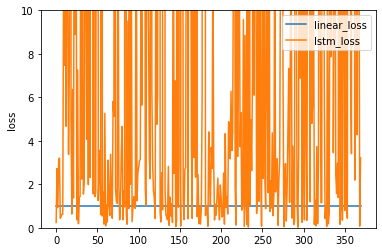

In [8]:
# 편차 제곱 그래프로 표시
plt.ylim(0, 10)
plt.plot(losslist_linear, label='linear_loss')
plt.plot(losslist_lstm, label='lstm_loss')
plt.ylabel('loss')
plt.legend()
plt.show()

In [9]:
(sum(losslist_linear), sum(losslist_lstm))

(370.0, 58614.44331055269)

In [10]:
lst = []
for item in losslist_lstm:
    if item < 1:
        lst.append(1)
    else:
        lst.append(0)
sum(lst)

93